# Open Context Zooarchaeology Measurements

This code gets meaurement data from Open Context to hopefully do some interesting things.

In the example given here, we're retrieving zooarchaeological measurements of fused metatarsal III/IV bones classified as "Artiodactyla" (including more specific taxonomic catagories). The specific query used to select these bone data is:

https://opencontext.org/query/?cat=oc-gen-cat-bio-subj-ecofact---oc-gen-cat-animal-bone&prop=obo-foodon-00001303---gbif-1---gbif-44---gbif-359---gbif-731&prop=oc-zoo-has-anat-id---obo-uberon-0002091---obo-uberon-0013588&prop=oc-zoo-von-den-driesch-bone-meas&type=subjects#aq=oc-zoo-von-den-driesch-bone-meas/ovgrd=oc/zm=4/ov=sqr/lat=46.07/lng=16.17

The OpenContextAPI() class has methods to get records from the query above by making multiple API requests to fetch records from Open Context. It also does some cosmetic processing of these records to populate a Pandas dataframe. This notebook also has some functions defined to generate scatter plots from the records retrieved via the OpenContextAPI() class.

In [1]:
# This imports the OpenContextAPI from the api.py file in the
# opencontext directory.
%run '../opencontext/api.py'

Below I define two little utility functions to make scatter plots from the data contained in a dataframe that was populated by the OpenContextAPI() class. The first function `make_group_markers_colors_for_df` makes dicts that associate markers and colors for different values in the `group_col`. The second function `make_scatter_plot_from_oc_df` makes scatter plots.

In [2]:

import matplotlib.pyplot as plt
import matplotlib.cm as cm

def make_group_markers_colors_for_df(df, group_col):
    """Makes group markers and colors for consistence in multiple plots"""
    # Make a list of markers that we will associate with different
    # grouping values for our scatter plots.
    markers = [
        'o',
        'x',
        'v',
        'D',
        'p',
        '^',
        's',
        '*',
    ]
    
    group_vals = df[group_col].unique().tolist()
    group_vals.sort()
    
    # Each value from the grouping column will get a color
    # assigned.
    colors = cm.rainbow(np.linspace(0, 1, len(group_vals)))
    group_markers = {}
    group_colors = {}
    m_i = 0
    for i, group_val in enumerate(group_vals):
        group_markers[group_val] = markers[m_i]
        group_colors[group_val] = colors[i].reshape(1,-1)
        m_i += 1
        if m_i >= len(markers):
            # We ran out of markers, so restart
            # the marker index.
            m_i = 0
    # Return a tuple of group markers and color dicts.
    return (
        group_markers,
        group_colors,
    )
    
    

def make_scatter_plot_from_oc_df(
    df, 
    group_col, 
    x_col, 
    y_col,
    group_markers=None,
    group_colors=None,
):
    """Make a scatter plot from an Open Context dataframe"""
    if not set([group_col, x_col, y_col]).issubset(set(df.columns.tolist())):
        raise('Check for missing columns')
    
    if not group_markers or not group_colors:
        # These were't passed as arguments so make them.
        group_markers, group_colors = make_group_markers_colors_for_df(
            df, 
            group_col
        )

    group_vals = df[group_col].unique().tolist()
    group_vals.sort()
    
    ax = None
    for group_val in group_vals:
        act_index = (
            (df[group_col] == group_val)
            & ~df[x_col].isnull()
            & ~df[y_col].isnull()
        )
        if df[act_index].empty:
            # No data for this taxon
            continue
        label = '{} [n={}]'.format(group_val, len(df[act_index].index))
        if not ax:
            ax = df[act_index].plot.scatter(
                x=x_col, 
                y=y_col, 
                marker=group_markers[group_val], 
                label=label, 
                color=group_colors[group_val],
            )
            ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        else:
            plot = df[act_index].plot.scatter(
                x=x_col, 
                y=y_col, 
                marker=group_markers[group_val],  
                label=label, 
                ax=ax, 
                color=group_colors[group_val],
            )
            plot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [3]:
import numpy as np
import pandas as pd

oc_api = OpenContextAPI()

# The cache file prefix defaults to today's date. This means that, by default,
# the cache expires after a day. To keep cached files indefinately, we can
# change the cache file prefix to something else that won't change from day
# to day.
oc_api.set_cache_file_prefix('plot-demo')

# Clear old cached records.
oc_api.clear_api_cache()

# This is a search/query url to Open Context.
url = 'https://opencontext.org/query/?cat=oc-gen-cat-bio-subj-ecofact---oc-gen-cat-animal-bone&prop=obo-foodon-00001303---gbif-1---gbif-44---gbif-359---gbif-731&prop=oc-zoo-has-anat-id---obo-uberon-0002091---obo-uberon-0013588&prop=oc-zoo-von-den-driesch-bone-meas&type=subjects#aq=oc-zoo-von-den-driesch-bone-meas/ovgrd=oc/zm=4/ov=sqr/lat=46.07/lng=16.17'

# Fetch the 'standard' (linked data identified) attributes in use with
# data at the url.
stnd_attribs_tuples = oc_api.get_standard_attributes(
    url,
    # The optional argument below gets popular standard
    # zooarchaeological (bone) measurements.
    add_von_den_driesch_bone_measures=True
)

        

GET Success for JSON data from: https://opencontext.org/query/?cat=oc-gen-cat-bio-subj-ecofact---oc-gen-cat-animal-bone&prop=obo-foodon-00001303---gbif-1---gbif-44---gbif-359---gbif-731&prop=oc-zoo-has-anat-id---obo-uberon-0002091---obo-uberon-0013588&prop=oc-zoo-von-den-driesch-bone-meas&type=subjects#aq=oc-zoo-von-den-driesch-bone-meas/ovgrd=oc/zm=4/ov=sqr/lat=46.07/lng=16.17


In [4]:
# Make a list of only the slugs from the list of slug, label tuples.
stnd_attribs = [slug for slug, _ in stnd_attribs_tuples]

# Make a dataframe by fetching result records from Open Context.
# This will be slow until we finish improvements to Open Context's API.
# However, the results get cached by saving as files locally. That
# makes iterating on this notebook much less painful.
df = oc_api.url_to_dataframe(url, stnd_attribs)

## Making some Plots
Because we're going to make multiple plots, lets make some consistent markers and colors for the different taxa in our dataset. This will make it easier to compare results in different plots.

In [5]:
group_markers, group_colors = make_group_markers_colors_for_df(
    df, 
    group_col='Has taxonomic identifier'
)

### Observing an outlier
The plot below will illustrate an outlier in our data.

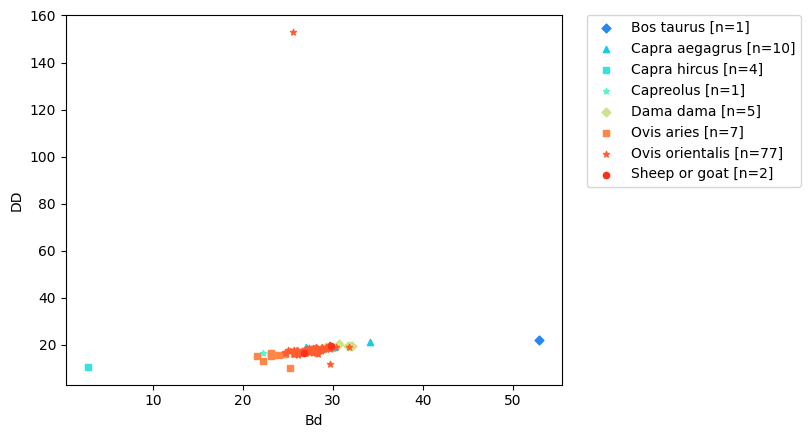

In [6]:
# Make a plot of Bd verses DD for different taxa
make_scatter_plot_from_oc_df(
    df, 
    group_col='Has taxonomic identifier', 
    x_col='Bd', 
    y_col='DD',
    group_markers=group_markers,
    group_colors=group_colors,
)



### Excluding the outlier
We can make a more reasonable plot by throwing out the outlier record (perhaps a recording error?) from the plot. To make this easier to read, we pass the same set of colors and markers for the different taxonomic values into the function that makes this plot.

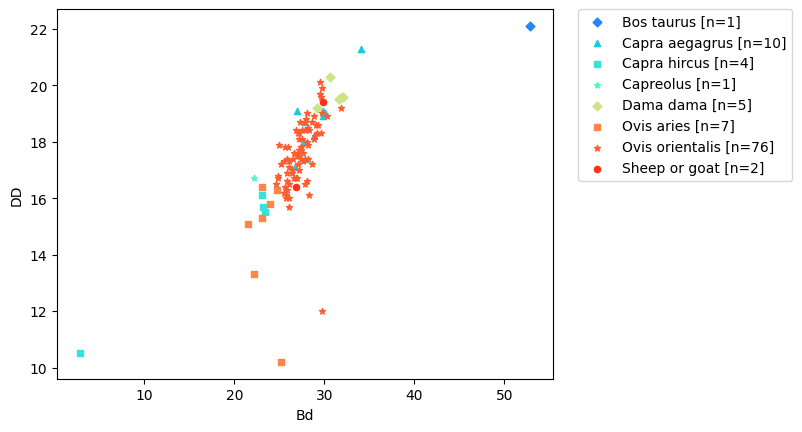

In [7]:
# Make a plot of Bd verses DD for different taxa, limiting DD to reasonable values.
make_scatter_plot_from_oc_df(
    df[(df['DD'] < 80)], 
    group_col='Has taxonomic identifier', 
    x_col='Bd', 
    y_col='DD',
    group_markers=group_markers,
    group_colors=group_colors,
)

### A more interesting plot, using proximal end measurements
Now to try another scatter plot, looking at measurements from the proximal end of the bone rather than the distal. In this plot the different animal taxa are much more clearly grouped.

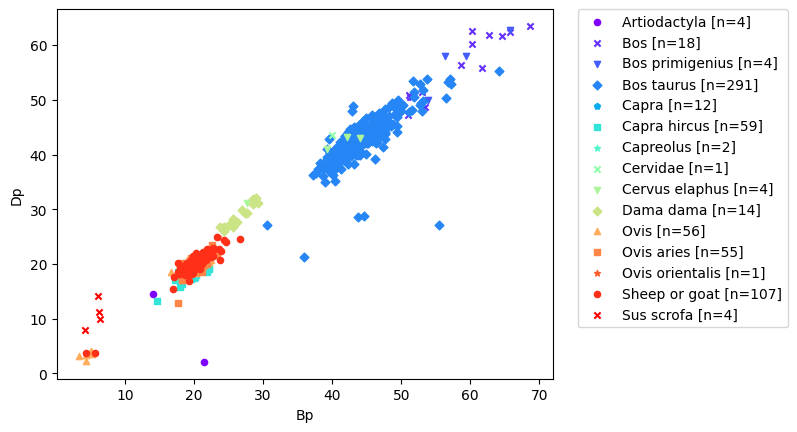

In [8]:
# Make a plot of Bp verses Dp for different taxa
make_scatter_plot_from_oc_df(
    df, 
    group_col='Has taxonomic identifier', 
    x_col='Bp', 
    y_col='Dp',
    group_markers=group_markers,
    group_colors=group_colors,
)

### Excluding suspect taxa
While the chart above is helpful, pigs have metatarsal III and metatarsal IV as seperate bones. So we should not see pigs in a query for metatarsal III/IV bone specimens. We should revise this plot to remove *Sus scrofa*.

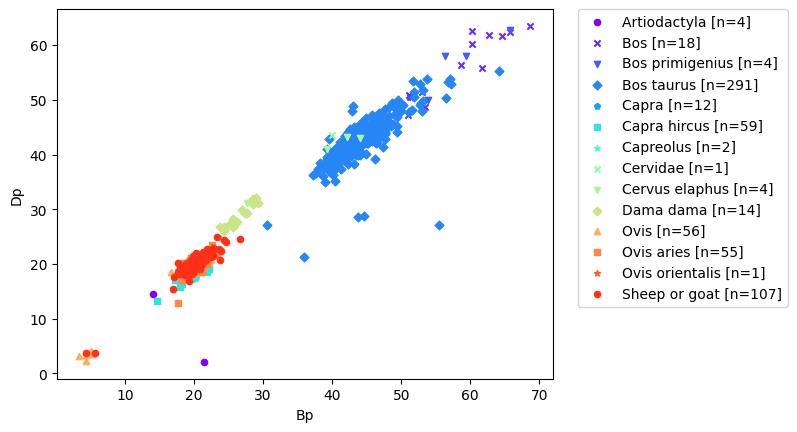

In [9]:
# Make a plot of Bp verses Dp for different taxa, excluding pigs
make_scatter_plot_from_oc_df(
    df[~df['Has taxonomic identifier'].str.startswith('Sus')], 
    group_col='Has taxonomic identifier', 
    x_col='Bp', 
    y_col='Dp',
    group_markers=group_markers,
    group_colors=group_colors,
)

To further explore the data, we include this plot that illustrates some taxonomic patterning of distal end measurements.

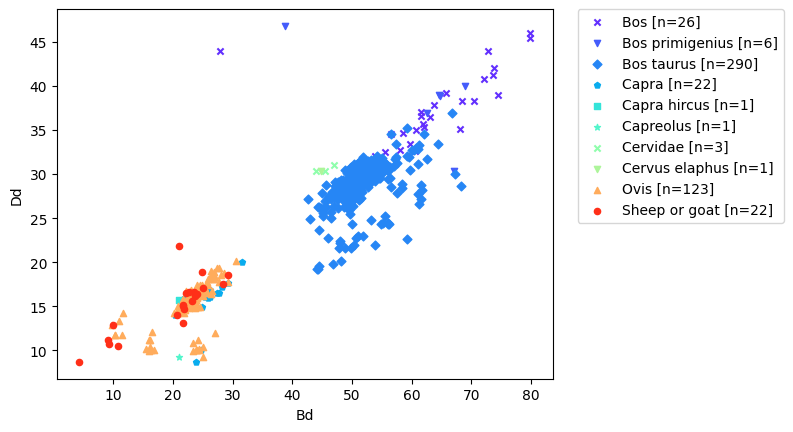

In [10]:
# Check some relationships in distal end measurements, also excluding pigs
make_scatter_plot_from_oc_df(
    df[~df['Has taxonomic identifier'].str.startswith('Sus')], 
    group_col='Has taxonomic identifier', 
    x_col='Bd', 
    y_col='Dd',
    group_markers=group_markers,
    group_colors=group_colors,
)